In [1]:
import plotly
import plotly.express as px
import sys
import pandas as pd
import numpy as np
import re
import csv
import unicodedata
import sys
import time
import pickle
import copy
import pickle
from collections import defaultdict
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import KNNBaseline,KNNWithMeans, SVD
from surprise import get_dataset_dir
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise import Reader
from joblib import dump

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

import warnings
warnings.filterwarnings("ignore")



UsageError: Line magic function `%` not found.


In [3]:
source_file = "BeerDataScienceProject.csv"
model_folder ='models'
output_dir = 'model_folder/'

In [34]:
from pathlib import Path
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [4]:
df = pd.read_csv(source_file,encoding='latin-1')

# How do find similar beer drinkers by using written reviews only

In [5]:
df.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206


In [6]:
df = df[["review_profileName","beer_name","review_overall"]]
df.head()

,review_profileName,beer_name,review_overall
0,stcules,Sausa Weizen,1.5
1,stcules,Red Moon,3.0
2,stcules,Black Horse Black Beer,3.0
3,stcules,Sausa Pils,3.0
4,johnmichaelsen,Cauldron DIPA,4.0


In [8]:
def remove_space(string):
    """
    to remove space at end of beer name
    """
    try:
        assert isinstance(string, str)
    except AssertionError:
        raise TypeError('Invalid input, this function expects string inputs.')
    return string.rstrip()

In [9]:
df.beer_name = df.beer_name.apply(lambda x: remove_space(x))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528870 entries, 0 to 528869
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   review_profileName  528755 non-null  object 
 1   beer_name           528870 non-null  object 
 2   review_overall      528870 non-null  float64
dtypes: float64(1), object(2)
memory usage: 12.1+ MB


In [11]:
df = df.drop_duplicates()

In [12]:
df.shape

(526515, 3)

In [13]:
df =df.dropna()
print(f"shape of data after drop:{df.shape[0]}")

shape of data after drop:526402


C:\Users\gazal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gazal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of Review Counts')

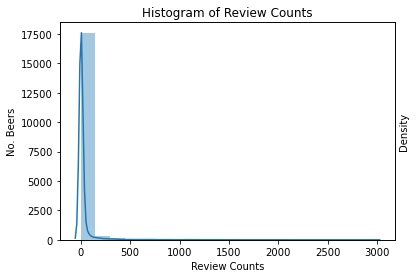

In [14]:
data= df.beer_name.value_counts()

# Plotting hist without kde
ax = sns.distplot(data, bins=20, kde=False)

# Creating another Y axis
second_ax = ax.twinx()

# Plotting kde without hist on the second Y axis
sns.distplot(data, ax=second_ax, kde=True, hist=False)

#Removing Y ticks from the second axis
second_ax.set_yticks([])

# Set labels
ax.set_xlabel('Review Counts')
ax.set_ylabel('No. Beers')
ax.set_title("Histogram of Review Counts")

In [17]:
grouped_beers = df.groupby('beer_name')

In [16]:
# grouped_beers.first()

,review_profileName,review_overall
beer_name,,
"""100"" Pale Ale",atsprings,4.0
"""33"" Export",TheKingofWichita,3.0
"""76"" Anniversary Ale",vacax,4.0
"""76"" Anniversary Ale With English Hops",womencantsail,4.0
"""Fade To Black"" Porter",Jayli,4.0
...,...,...
Über Pils,mynie,4.5
ÜberFest Pilsner,magictrokini,3.5
ÜberSun (Imperial Summer Wheat Beer),jsp2,4.5


In [18]:
grouped_beers.count().sort_values(by='review_profileName', ascending = False).quantile(np.arange(0,1,.05))

,review_profileName,review_overall
0.00,1.0,1.0
0.05,1.0,1.0
0.10,1.0,1.0
0.15,1.0,1.0
0.20,1.0,1.0
0.25,1.0,1.0
0.30,1.0,1.0
0.35,2.0,2.0
0.40,2.0,2.0
0.45,2.0,2.0


In [19]:
grouped_beers.mean().sort_values(by='review_overall', ascending = False).quantile(np.arange(0,1,.05))

,review_overall
0.00,1.000000
0.05,2.500000
0.10,2.904091
0.15,3.000000
0.20,3.250000
0.25,3.400000
0.30,3.500000
0.35,3.500000
0.40,3.583333
0.45,3.700000


In [20]:
avg_rating = grouped_beers.mean()

# I am definining beers with average rating less than 3.5 to be considered subpar 
# since a 3.5 avg rating would put it in the bottom 10 percentile of these beers
subpar_average_mask = avg_rating['review_overall'] < 3.5
subpar_beers_count = len(avg_rating[subpar_average_mask])

print('{} beers have a average rating less than 3.5'.format(subpar_beers_count))
print('A 3.5 avg rating puts the beer within the bottom 10%-tile')

4902 beers have a average rating less than 3.5
A 3.5 avg rating puts the beer within the bottom 10%-tile


In [21]:
# distribution of the bottom 10% in average rating, and number of rating counts
bottom_10percent_rating = grouped_beers.mean().quantile(np.arange(0,.11,.01))
bottom_10percent_counts = grouped_beers.count().quantile(np.arange(0,.11,.01))

In [22]:
bottom_10percent_rating

,review_overall
0.00,1.000000
0.01,1.500000
0.02,2.000000
0.03,2.000000
0.04,2.333333
0.05,2.500000
0.06,2.500000
0.07,2.500000
0.08,2.750000
0.09,2.800000


In [ ]:
bottom_10percent_counts

C:\Users\gazal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gazal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of User Counts')

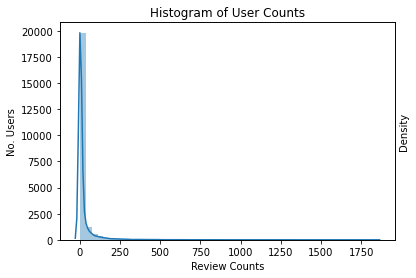

In [23]:
data2= df.review_profileName.value_counts()

# Plotting hist without kde
ax2 = sns.distplot(data2, kde=False)

# Creating another Y axis
second_ax2 = ax2.twinx()

# Plotting kde without hist on the second Y axis
sns.distplot(data2, ax=second_ax2, kde=True, hist=False)

#Removing Y ticks from the second axis
second_ax2.set_yticks([])

# Set labels
ax2.set_xlabel('Review Counts')
ax2.set_ylabel('No. Users')
ax2.set_title("Histogram of User Counts")

In [24]:
grouped_users = df.groupby('review_profileName')

In [25]:
grouped_users_count = grouped_users.count()

counts = [1,2,3,4,5,10,15,20]
for ct in counts:
    num_users = grouped_users_count[grouped_users_count['review_overall'] <= ct].count()[0]
    print('{} users rated {} or less beers'.format(num_users,ct))

print('\n')
print('Total Unique Users in this dataset: {}'.format(len(df.review_profileName.unique())))

7700 users rated 1 or less beers
10625 users rated 2 or less beers
12335 users rated 3 or less beers
13485 users rated 4 or less beers
14316 users rated 5 or less beers
16635 users rated 10 or less beers
17736 users rated 15 or less beers
18474 users rated 20 or less beers


Total Unique Users in this dataset: 22800


In [26]:
subpar_beers_list = list(avg_rating[subpar_average_mask].index)

ratings_count = grouped_beers.count()

# I am definining beers with ratings count less than 13 to be considered low amount of ratings 
# since a ratings count of 13 would put it in the bottom 10 percentile
low_ratings_count = ratings_count[ratings_count['review_overall'] < 13]
low_ratings_list = list(low_ratings_count.index)

In [27]:
unique_subpar_beers = set(subpar_beers_list)
unique_low_ratings_beers = set(low_ratings_list)
overlaps = unique_subpar_beers.intersection(unique_low_ratings_beers)
print('Number of beers in bottom 10% of avg rating: {}'.format(len(unique_subpar_beers)))
print('Number of beers in bottom 10% of review counts: {}'.format(len(unique_low_ratings_beers)))
print('Number of beers in both of these categories: {}'.format(len(overlaps)))

Number of beers in bottom 10% of avg rating: 4902
Number of beers in bottom 10% of review counts: 14699
Number of beers in both of these categories: 4062


In [28]:
#remove beers in the bottom 10% of both categories
df1 = df[~df.beer_name.isin(subpar_beers_list)]
df2 = df1[~df1.beer_name.isin(low_ratings_list)]
user_reviews_df2 = copy.deepcopy(df2)

In [29]:
print('Original number of unique beers: {}'.format(len(df.beer_name.unique())))

print('Revised number of unique beers: {}'.format(len(user_reviews_df2.beer_name.unique())))

Original number of unique beers: 18339
Revised number of unique beers: 2800


In [ ]:
user_reviews_df2

In [30]:
# create beerID for each beer

grouped_name = user_reviews_df2.groupby('beer_name')

temp_df = grouped_name.count()
temp_df_idx = pd.DataFrame(temp_df.index)


temp_df_idx['beerID'] = temp_df_idx.index
dict_df=temp_df_idx[['beerID','beer_name']]


desc_dict = dict_df.set_index('beer_name').to_dict()
new_dict = desc_dict['beerID']

user_reviews_df2['beerID'] = user_reviews_df2.beer_name.map(new_dict)



# create userID for each user
grouped_user = user_reviews_df2.groupby('review_profileName')

temp_df_user = grouped_user.count()
temp_df_user_idx = pd.DataFrame(temp_df_user.index)


temp_df_user_idx['userID']=temp_df_user_idx.index
dict_df_user=temp_df_user_idx[['userID','review_profileName']] 


desc_dict_user = dict_df_user.set_index('review_profileName').to_dict()
new_dict_user = desc_dict_user['userID']

user_reviews_df2['userID'] = user_reviews_df2.review_profileName.map(new_dict_user)

In [40]:

def read_item_names():
    """
    return two mappings to convert raw ids into beer names 
    and beer names into raw ids.
    """

    file_name = dict_df
    rid_to_name = {}
    name_to_rid = {}

    # there are 3959 unique beers after removing the low rating and review count beers
    unique_beers = len(user_reviews_df2.beer_name.unique())
    
    for i in range(unique_beers):  
        line = file_name.iloc[i]
        rid_to_name[line[0]] = line[1]
        name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid

In [31]:
def get_rec(beer_name, k_):
    """
    Input Beer name and returns k recommendations
    based on item similarity
    
    Input: String, integer
    Output: String
    """
    output = []
    
    beer = str(beer_name)

    # Read the mappings raw id <-> beer name
    rid_to_name, name_to_rid = read_item_names()

    # Retrieve inner id of the Beer
    beer_input_raw_id = name_to_rid[beer]
    beer_input_inner_id = algo.trainset.to_inner_iid(beer_input_raw_id)

    
    K = k_
    
    # Retrieve inner ids of the nearest neighbors of the Beer
    beer_input_neighbors = algo.get_neighbors(beer_input_inner_id, k=K)

    
    # Convert inner ids of the neighbors into names.
    beer_input_neighbors = (algo.trainset.to_raw_iid(inner_id)
                                for inner_id in beer_input_neighbors)
    beer_input_neighbors = (rid_to_name[rid]
                                for rid in beer_input_neighbors)

    for beer_ in beer_input_neighbors:
        output.append(beer_)
        
    return output

In [ ]:
user_reviews_df2

In [32]:

reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(user_reviews_df2[['userID', 'beerID', 'review_overall']], reader)
kf = KFold(n_splits=5)
sim_options = {'name':'cosine', 'user_based':False}
algo = KNNWithMeans(sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_algo = algo
        best_rmse= rmse
        best_pred = predictions


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.0112
Computing the cosine similarity matrix...


C:\Users\gazal\anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
RMSE: 3.0098
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.0090
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.0090
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.0130


In [35]:
with open(output_dir +'beer_model_pkl', 'wb') as files:
    pickle.dump(best_algo, files)

In [36]:
# top 20 most rated beers
grouped_beer_names = user_reviews_df2.groupby('beer_name')
grouped_beer_names.count().sort_values(by='review_profileName', ascending =False)[0:20].index.tolist()

['Sierra Nevada Celebration Ale',
 'Sierra Nevada Pale Ale',
 'La Fin Du Monde',
 'Founders Breakfast Stout',
 'Sierra Nevada Bigfoot Barleywine Style Ale',
 'Samuel Adams Boston Lager',
 'Dead Guy Ale',
 'Chocolate Stout',
 'Trappistes Rochefort 10',
 "Samuel Smith's Oatmeal Stout",
 'Sierra Nevada Torpedo Extra IPA',
 'Chimay Grande Réserve (Blue)',
 'Racer 5 India Pale Ale',
 'Orval Trappist Ale',
 'Tröegs Nugget Nectar',
 'Founders KBS (Kentucky Breakfast Stout)',
 'Hop Rod Rye',
 'Samuel Adams Octoberfest',
 'Samuel Adams Winter Lager',
 'Trois Pistoles']

In [37]:
grouped_beer_names

In [38]:
# top 20 highest rating beers
grouped_beer_names.mean().sort_values(by='review_overall', ascending =False)[0:20].index.tolist()

['Southampton Berliner Weisse',
 'Citra DIPA',
 'Cantillon Blåbær Lambik',
 'Heady Topper',
 "Mo' Betta Bretta",
 'Founders CBS Imperial Stout',
 'Samuel Adams Millennium',
 'Gold Stock Ale',
 "Nickel Bag - O'Brien's 17th Anniversary",
 'Great Lakes Wolfhound Stout',
 'Cuir (100% Bourbon Barrel Aged)',
 'Cantillon Loerik',
 "Hunahpu's Imperial Stout - Rum Barrel Aged",
 'Masala Mama India Pale Ale',
 'Humulus Lager',
 'AleSmith Speedway Stout - Kopi Luwak',
 '5th Anniversary Ale',
 'Mecktoberfest',
 'Rye Wit',
 'John Brown Pale Ale']

In [43]:
print('The 5 nearest neighbors of Southampton Berliner Weisse:')
get_rec('Southampton Berliner Weisse',5)

The 5 nearest neighbors of Southampton Berliner Weisse:


['Samuel Adams Harvest Pumpkin Ale',
 'Russian Imperial Stout',
 'Back Forty Bock',
 'Headwall Alt',
 'Sir Duluth Oatmeal Stout']

In [ ]:
print('The 5 nearest neighbors of Caldera Pale Ale are:')
get_rec('Caldera Pale Ale',5)

# User based Model

In [44]:
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(user_reviews_df2[['userID', 'beerID', 'review_overall']], reader)
kf = KFold(n_splits=5)
sim_options = {'name':'cosine', 'user_based':True}
algo = KNNWithMeans(sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_algo = algo
        best_rmse= rmse
        best_pred = predictions
with open(output_dir + 'user_model_pkl', 'wb') as files:
    pickle.dump(best_algo, files)

Computing the cosine similarity matrix...


C:\Users\gazal\anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
RMSE: 3.0101
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.0127
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.0099
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.0102
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.0092


In [45]:
def read_user_names():
    """
    return two mappings to convert raw ids into user names 
    and user names  into raw ids.
    """

    file_name = dict_df_user
    rid_to_name = {}
    name_to_rid = {}

    # there are 3959 unique beers after removing the low rating and review count beers
    unique_users = len(user_reviews_df2.review_profileName.unique())
    
    for i in range(unique_users):  
        line = file_name.iloc[i]
        rid_to_name[line[0]] = line[1]
        name_to_rid[line[1]] = line[0]
    return rid_to_name, name_to_rid

In [46]:
def get_rec_user(user_name, k_):
    """
    Input Beer name and returns k recommendations
    based on item similarity
    
    Input: String, integer
    Output: String
    """
    output = []
    
    user = str(user_name)

    # Read the mappings raw id <-> beer name
    rid_to_name, name_to_rid = read_user_names()

    # Retrieve inner id of the Beer
    beer_input_raw_id = name_to_rid[user]
    beer_input_inner_id = algo.trainset.to_inner_uid(beer_input_raw_id)
    print(beer_input_inner_id)

    K = k_
    
    # Retrieve inner ids of the nearest neighbors of the Beer
    beer_input_neighbors = algo.get_neighbors(beer_input_inner_id, k=K)

    
    # Convert inner ids of the neighbors into names.
    beer_input_neighbors = (algo.trainset.to_raw_iid(inner_id)
                                for inner_id in beer_input_neighbors)
    beer_input_neighbors = (rid_to_name[rid]
                                for rid in beer_input_neighbors)

    for beer_ in beer_input_neighbors:
        output.append(beer_)
        
    return output

In [47]:
get_rec_user("dyan",2)

---------------------------- {0: '0110x011', 1: '03SVTCobra', 2: '04101Brewer', 3: '05Harley', 4: '0tt0', 5: '1000Bottles', 6: '1001111', 7: '100floods', 8: '100proof', 9: '104bob', 10: '1050Sudz', 11: '108Dragons', 12: '1099', 13: '10bear', 14: '1100', 15: '110toyourleft', 16: '1121987', 17: '11millsown113', 18: '11osixBrew', 19: '12NattiBottles', 20: '12percent', 21: '12puebloyankee', 22: '12vUnion', 23: '13aphomet', 24: '160Shillings', 25: '1759Girl', 26: '1759dallas', 27: '1844original', 28: '18alpha', 29: '196osh', 30: '1993Heel', 31: '1Adam12', 32: '1BeerLeague', 33: '1MiltonWaddams', 34: '1Paradisebrew', 35: '1after909', 36: '1brbn1sctch1beer', 37: '1fastz28', 38: '1lastcast', 39: '1morebeer', 40: '1noa', 41: '1p3261', 42: '1quiks10', 43: '1realbeer', 44: '1santore', 45: '1thinmint', 46: '1whiskey', 47: '20ozmonkey', 48: '21mmer', 49: '220emaple', 50: '2378GCGTG', 51: '23fyerfyter', 52: '24Beer92', 53: '289extrajoss', 54: '28Rock', 55: '2BDChicago', 56: '2Cruzy', 57: '2DaMtns', 

['DArinello', 'BrewDoc12']

In [48]:
val =dict_df_user.query("review_profileName =='DAVIDTHEBANDIT' ")
print(val)

      userID review_profileName
2112    2112     DAVIDTHEBANDIT


In [49]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [50]:
def predict__users(uid, k):
        uid = self.transform_dataframe(feat='user_id',ii=uid)
        tsr_inner_id = self.model.trainset.to_inner_uid(uid)
        tsr_neighbors = self.model.get_neighbors(tsr_inner_id, k=k)
        val= self.users[self.users.user_id.isin([self.model.trainset.to_raw_uid(inner_id)
                       for inner_id in tsr_neighbors])]
        lst = val['user_id'].tolist()
        lst = self.inverse_transformer('user_id',lst)
        return lst

In [51]:
top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

709 [2573, 1223, 2395, 715, 73, 2240, 1004, 183, 1996, 2096]
4122 [1220, 2120, 2110, 1116, 2549, 434, 2358, 2638, 597, 1505]
17039 [2135, 870, 1558, 2223, 1744, 738, 2212, 554, 2336, 2244]
4474 [1231, 2410, 872, 2528, 565, 1522, 1278, 1141, 1943, 1750]
4432 [2488, 568]
10874 [1255, 1597, 879, 178, 1948, 756, 212, 1432, 1366, 865]
5359 [1800, 2760, 714, 2526, 1048, 2405, 2660, 1780, 1943, 1077]
6246 [2223, 1035, 2095, 1213, 1802, 1182, 804]
15731 [2111, 2074, 2095, 2077, 1575, 889, 2117, 212, 714, 349]
306 [373, 1281, 2592, 2683, 416, 1402, 889, 865, 1597, 1004]
9105 [281, 141, 443, 2056, 1964, 529, 1944, 2325, 970, 481]
5584 [2132, 260, 835, 2606, 2776, 206, 1328, 1472, 121, 2667]
10646 [888, 949, 1920]
1329 [370, 626, 368, 1385, 622, 567, 574, 1318, 1120, 411]
12707 [2347, 1592, 1071, 922, 1783, 1053, 1028, 568, 2477, 1752]
13552 [2781, 1943, 2128, 1029, 676, 706, 2080, 2242, 1434, 2764]
5271 [772, 1009, 829, 859, 2526, 2672, 1010, 566, 2639, 1116]
6767 [2212, 2547, 576, 1096, 1341, 9

9973 [2117]
10433 [2318, 2746, 491, 1997, 1277, 501, 497, 215, 1467, 1622]
15517 [2573, 2246, 969, 1967, 1155, 865, 1703]
12071 [359]
16748 [2776, 2547]
10631 [2248, 560, 2239, 491, 121, 2076, 2070, 2578, 2730, 2488]
8678 [848, 879, 285, 1346, 2133, 2303, 870, 2056, 138, 729]
5647 [715, 26, 2194, 1662, 1998, 1231, 1677, 2526, 653, 2791]
5057 [1021, 591, 2130, 1930, 1852, 2115, 835, 835, 877, 2212]
1586 [1053, 2348, 1071, 510, 1430, 2133, 92, 1121, 1548, 1669]
164 [1802, 2259, 1324, 2730, 1066, 2603, 573, 2554, 2627, 1271]
17309 [215, 1945, 2060, 1038, 2460, 2791]
19322 [729, 1504, 342, 1920, 2391, 1353, 1102, 2605, 233, 1819]
13018 [1141, 1390, 1664, 2152, 1208, 2549, 870, 2612, 2323, 784]
12773 [981, 1093, 2110, 1588, 2108, 1144, 987, 1390, 1510, 976]
1393 [2231, 2097]
8516 [1538]
16037 [100, 1718, 2116, 676, 2432, 766, 2074, 958, 742, 2242]
18688 [146, 2296, 2786, 1588, 1908, 2590, 1901, 1441, 964, 1570]
8019 [1236, 2125, 189, 1307, 2085, 272, 273, 851, 1074, 1121]
20035 [2318, 1390]

5268 [13, 2223, 2311, 2547, 2237, 1231, 1509, 774, 327, 1094]
20812 [567, 1121, 1961, 11, 28, 2117, 865, 566, 2231, 1365]
9111 [1193]
8668 [2231, 2501, 218, 1233, 2242, 973, 2225, 868, 1678, 2610]
12583 [576, 2310, 1889, 2095, 859, 2240, 568, 2461, 1141, 472]
15141 [1755, 126, 969, 2547, 2585, 1380, 2034, 327, 568, 1869]
13453 [500, 1098, 2608, 1312, 2002, 866, 2613, 1276, 1944]
19213 [2573, 2142, 2460, 1522, 1703]
11713 [742]
6470 [1158, 1584, 2462, 2457, 700, 1881, 121, 2231, 2112, 2104]
9807 [2704, 2776, 717, 1178, 1743, 1883, 2304, 2101, 2747, 2244]
15425 [2781, 100]
13019 [2098, 1869, 1021, 2084]
12941 [566, 2079, 2096, 2086, 2112]
17776 [1088, 1719, 2569, 2559, 2240, 1847, 359, 1802, 1158, 2560]
15750 [2017, 712, 2455, 2443, 588]
20259 [2577, 738, 1864, 1098]
17138 [2725, 888, 676, 1897, 1271, 142, 2116, 772, 106, 2604]
16557 [2116]
13860 [2227, 872]
18062 [1019, 1341, 2249]
16496 [1412]
2440 [1369, 324, 873, 1178, 1607, 2097, 2, 2080, 2227, 1488]
10290 [700, 2117, 2601, 2073, 94

18228 [1833]
19218 [749, 1462, 2249]
8104 [2747, 2777, 891, 2791, 2573, 243, 62, 2560, 536, 2304]
2990 [572, 2624, 888, 2289, 2528, 52]
1381 [2116, 2133, 2373, 925]
5593 [1093, 729]
11781 [2105, 2515, 2286, 1526, 1412, 2212, 1812, 1050, 2431, 627]
8619 [260, 1214, 989, 2559, 489, 2252, 2248, 983, 2060, 1310]
9409 [122]
15728 [2227, 676]
6292 [2073, 2798, 2577, 1751, 2087, 738]
6717 [11, 2074, 2070, 835, 2262, 2065]
13901 [796]
20542 [870, 359, 1707, 925, 1242, 2383, 2281, 556, 1466, 1487]
515 [1231, 2623, 2336, 2621, 2747]
15494 [2770]
10871 [1466]
7005 [2242]
4748 [296]
9426 [2057]
12351 [2607, 2076, 2593, 1395, 1605, 2092, 2232, 2238, 1295, 1847]
7386 [1718, 2597, 2244, 2616, 2558, 717, 656, 1526, 873, 66]
4889 [750, 2242, 975, 976, 2238, 2104]
9145 [365, 1365, 1235, 865, 2415, 868, 499, 501, 1236, 924]
14036 [206, 2237, 1998, 2796, 2117, 576, 872, 32, 2090, 1755]
6777 [1807, 2232, 878, 1596, 436, 1214, 1963, 1244, 2006, 729]
20167 [1141]
20337 [1239, 2087, 2111, 676, 2104, 2096, 222

12968 [718]
6059 [683, 1538, 1854, 2578, 486, 2525, 1310, 2050, 233, 2346]
7997 [2472]
46 [1051, 1271, 1854, 2227, 1180, 2076]
8849 [2104, 1113, 1867]
13255 [100]
1364 [2790]
15999 [869, 2573, 1251, 1340, 699, 878, 891, 1821, 2240, 2323]
5115 [870]
7992 [706, 2604, 700, 511, 676, 1526, 2231, 2247]
10812 [1382, 379, 2549, 568, 566, 2547]
1778 [282, 1607, 2689]
2027 [1098]
7301 [2086, 1029]
18374 [1802]
13772 [1581, 2710]
7195 [2791]
14888 [2104, 2130, 2117]
3428 [1961]
9629 [2101, 2076, 1239, 2070, 1028, 2074, 2006]
1808 [976, 1074, 987, 1836, 2786]
11426 [2638, 1386, 1750]
11919 [2242, 2227, 121, 676]
20148 [835, 1961]
14863 [113, 2536, 2336, 1073, 2538, 2597, 865, 359, 1381, 1183]
8095 [2742, 1062, 1003, 369, 412, 2561, 1755]
137 [2112, 2006, 2549, 2283, 1235, 459, 1526, 1566, 1110]
15020 [386, 656, 576, 2547, 2084, 2565, 769, 1566, 874, 1920]
17511 [2567, 2249, 2639]
18219 [865, 1295, 2060]
3944 [576, 1783, 870]
16205 [879, 32, 1295, 976, 1669, 1060, 1998]
2082 [2096, 2262, 1144, 169

3753 [2246, 28, 2571, 2573, 2112, 1526, 975, 976]
9388 [2682, 717, 1230, 2700]
205 [2549, 2091, 2548, 2242]
20684 [1413, 2249, 1677, 891, 2747]
2719 [2242, 2074, 2067, 706, 2713, 2020, 2483, 2730, 373]
6204 [1187, 1147]
15358 [172, 610, 1093]
11849 [1959, 865, 717, 1864, 1141, 676, 2575, 1697, 568, 2101]
20713 [2131, 729, 2242, 1340]
12032 [1530]
18440 [2111, 2242]
7504 [2114, 2122, 1220, 1385, 2588]
17748 [2476, 1687, 903, 2473]
9491 [566, 1029, 265, 2770, 2582, 1783, 2525, 1740, 2560, 2558]
2323 [865, 77]
4909 [1943]
17728 [100, 2117]
8974 [2776, 47, 572]
17549 [2112, 2074]
19104 [2558, 568]
15613 [731, 925]
4222 [2242, 359, 683, 2416, 2462]
7590 [2560]
1649 [2242, 1121, 2115]
10520 [64, 575, 2769, 970, 2435, 282, 1235]
14134 [2528, 575, 879]
12404 [1869, 2549, 170, 1689, 1864, 158, 613, 2677, 1226, 688]
10195 [2070]
7190 [878]
3029 [2244, 1121, 2407]
7582 [1689, 1869]
3174 [2461, 2079, 2084, 1783, 2252, 928, 879, 2400, 380, 1386]
17397 [2111, 2115, 2194]
10673 [100, 1535, 2009, 2586

5001 [1214, 2086, 1783, 973, 2095, 2077]
11550 [2112, 1471, 866, 2111, 1762, 1998, 2443, 1736]
4 [2764, 1677, 2407]
2426 [2070, 1869, 2247, 2124, 97, 2781, 2364, 999, 98, 2097]
1068 [887]
3613 [1178, 2223]
16726 [450, 676]
2415 [1575, 529]
5170 [1864]
6857 [2558, 2597, 2104, 2242, 161, 2112, 575]
5790 [138, 1155, 1930, 1953, 566, 2381, 2128, 1432, 57, 1366]
11321 [1286, 2525, 2547]
3555 [1307, 379, 1239, 11, 2096, 167, 380, 2283]
15369 [1388, 1009, 1121, 749, 1170, 243]
4174 [1341, 8, 288, 1202]
5496 [2112]
11099 [700, 2283, 2231, 949, 281, 718]
14611 [1244, 2037, 817, 706, 1180, 349]
10007 [2198, 716, 1010, 1852, 1155]
7454 [2079, 2448, 2514]
15511 [2443]
2538 [879, 975, 2084, 2133, 1570, 2076, 976, 2274, 715, 796]
2603 [1862, 2074]
55 [2573, 2199, 1572, 2446]
5190 [2130, 1920, 1857, 2248, 2080]
7811 [2079, 2558, 66]
2553 [1033]
14684 [1566]
10131 [2065, 567, 106, 568, 566, 982]
10845 [2074, 2236]
11366 [792, 566, 2573, 1141]
8903 [38, 535, 1906, 482, 441, 2786, 477, 1141, 100, 529]
1

13806 [567, 2227, 2117, 844, 700, 2115]
16764 [2116, 1566, 1310, 1722, 2026, 2341, 1864, 242, 1013]
19179 [1137, 2283, 668, 887, 436]
10130 [1228, 2623]
7904 [879, 1021, 1751, 1575, 2791, 1964, 407, 874]
1044 [75]
18651 [1526, 975, 1035, 2583]
4125 [1231, 2547, 310]
16356 [2586, 1644, 2242, 2223, 1930, 2227, 2212, 281, 2556, 1703]
12750 [2096]
12980 [716, 94, 949, 1750, 66, 2509]
2458 [1741, 667, 1163]
6388 [1702, 1185, 94]
11329 [1930, 835, 1679]
19668 [976, 616]
8425 [888]
14602 [1877, 751, 899, 1035, 1583]
441 [1003, 227, 588, 1102, 993]
15576 [1465]
20078 [2110, 2273, 2133, 522, 678, 1901, 1981, 1035, 2432]
2863 [267]
17851 [706, 1947, 77]
14191 [984]
6873 [2199]
17324 [2573]
8220 [2564, 1029, 2515, 121, 738, 1593, 1920, 1226, 2569, 620]
13274 [491, 2283]
17850 [2105]
6173 [2086, 2114]
4347 [2086]
6669 [2339, 2098, 1751, 1783, 2130, 1596, 1995, 1959, 167, 1869]
10932 [874, 2416, 2092, 122, 1180]
12316 [1071, 1365, 1587]
5862 [2130]
19419 [2021, 2569, 2267, 2398]
1741 [1059]
555 [24

3825 [2249]
9350 [1071]
9229 [1783, 2443, 2231, 2458]
16211 [1239]
19321 [2104]
5333 [2074, 2065, 2070]
2411 [1869, 2244]
4346 [1679, 1783, 879]
15441 [1157, 436]
9129 [450, 1098, 2577, 439, 2114, 1045, 1133, 2596, 678, 1094]
14720 [566]
5535 [1183, 566, 1365, 2569, 2065, 1783, 1276, 1155]
18546 [33, 100]
16503 [874, 859, 2238]
6550 [1306, 874, 2660, 954]
5680 [30]
7656 [879]
17548 [28, 975, 2227]
3183 [1382, 2416]
1548 [949, 970]
2343 [1365]
1608 [1516]
6945 [1365, 2786, 2109, 2567, 1155, 2033]
260 [1947, 342, 822, 1304, 762]
18636 [1689]
15067 [1597, 896]
12812 [2360, 2560, 706]
15209 [757, 1155]
19871 [879, 6, 94, 897, 101, 1964]
3850 [1278]
14150 [371, 575]
19537 [2231, 2242, 743, 1744]
5164 [319]
9833 [2231, 2128]
6220 [272, 1193, 1677]
8443 [1920]
20629 [2055, 575, 2117, 1943, 1310]
13751 [2247, 958]
5459 [2117, 2559, 2776, 178]
929 [2247]
3368 [2098, 2112]
16716 [2617]
7183 [490, 1597, 1524, 1783, 949]
869 [620]
12046 [2111, 2096]
10517 [1121]
12477 [865, 868, 2781, 1566, 2247, 

13203 [2096, 34, 676, 2593, 981, 925, 976]
7925 [729]
6761 [730, 1071]
2396 [2595, 1115, 78]
12395 [2460]
726 [369]
16532 [878, 2573]
6138 [701, 1597]
9986 [1488, 359]
764 [1575, 2560, 2791, 2765]
18248 [2112]
7119 [1439]
17836 [2242, 359]
6195 [1963]
6028 [1998]
5237 [359, 2070, 2074]
20010 [1235]
11599 [2231]
12078 [2420]
17220 [1802, 835, 989]
2407 [2548]
2260 [1570, 729, 1566]
4248 [2095, 2223]
8217 [2601]
7969 [972]
10462 [929, 1158]
18004 [1566]
9319 [971]
2570 [2026, 1113]
8611 [1697, 1783, 308, 1297]
4560 [94, 1312, 796, 1953]
5723 [2283, 2086, 2244, 2223, 2231, 2707, 2097]
13409 [2549]
13354 [47]
6948 [575, 2574, 976]
9438 [1242, 2573, 2571]
5608 [1155, 868, 2191, 976, 38, 2601, 1045, 2132]
9249 [359]
4086 [974, 2715, 2242]
13288 [2563]
9047 [349]
17822 [866]
19947 [1702, 1943]
1270 [132]
17416 [2460]
9648 [591, 2117, 706]
4834 [866, 1310, 1488]
12557 [2394]
10571 [265]
15542 [2601]
15333 [729]
18068 [2560, 2242, 2601, 2573]
17702 [2127, 436, 755]
11030 [227]
7858 [2079]
2748 

2901 [1719, 2246, 1677, 2238]
17855 [43]
20019 [1121, 2111, 2073, 2102]
18668 [1981, 436]
14423 [1712, 2665, 2110, 132, 134]
747 [1930, 1471]
950 [2725]
20339 [970, 2739, 1744, 844, 472]
5315 [1019, 907, 212]
1165 [1365, 2547, 2549]
7964 [2244]
4982 [1572]
8941 [2394]
20715 [1840]
19306 [1435]
10635 [2273]
11076 [2786, 2096, 146]
6706 [2558]
14898 [1293]
11413 [2242]
11680 [712, 146]
13348 [2667, 2117, 949, 1546, 1155, 2242]
10412 [11, 683, 603]
6625 [1758]
19404 [865, 2244, 2231]
2460 [2101]
2117 [835, 2227, 2074, 2087, 2125]
12576 [714]
4817 [1943]
13905 [2167, 969]
8851 [1814]
16808 [642, 1836, 2421]
7009 [575]
10192 [2117, 2710]
1774 [1755, 100]
13614 [2096, 2074]
7401 [2549, 1035, 1750]
2877 [32, 892]
11137 [967]
7470 [676, 2400]
17756 [698]
17085 [1525]
1306 [2347]
7372 [359]
18734 [2079]
18856 [2575, 1920]
17233 [533]
12519 [2293]
16530 [2104]
3654 [2132]
8225 [566]
4320 [1487]
9570 [2126, 832]
5335 [1961]
15917 [2130]
18601 [2231, 976]
17160 [2249, 2115, 2713]
16674 [2130, 1365

11077 [2528]
1201 [369]
1687 [1526]
16120 [2240]
15252 [2547, 566]
475 [2346]
14021 [1442]
4185 [1584, 870, 471]
1507 [1092]
14584 [1225]
18189 [2098]
7963 [1783]
10116 [1214]
12276 [683]
17223 [2248]
9977 [865]
19395 [2095, 1278]
19331 [1783]
4026 [1920]
19136 [391, 923]
18132 [1071, 1566]
9883 [1373]
672 [975, 976]
5279 [35, 31]
7231 [1239, 718]
18975 [1074]
13459 [2573, 873]
6931 [2720]
101 [700]
10690 [1783, 2080, 1920]
13719 [2231]
4060 [877, 1886, 701]
9283 [796]
11692 [1920, 1780]
15312 [2222]
16679 [2024]
5880 [2115, 2276]
16960 [1623]
16182 [1783, 183, 1572]
17120 [1155]
3335 [2096]
3606 [776]
18961 [2084]
18581 [947]
2051 [2095]
9381 [2589]
9496 [1858, 1309, 849]
6506 [742]
2282 [2104]
19258 [1012, 2348]
13320 [1575]
15097 [2112]
6516 [1570]
9979 [1051, 1576]
10326 [2796]
9842 [865, 877]
6485 [2776, 1751]
136 [2304]
9528 [41]
2410 [2065]
15958 [2398]
6158 [2114, 566]
5391 [2283, 1310, 2249]
4415 [2092, 2231, 1402]
17761 [2573]
16953 [106]
425 [1728]
4431 [2117]
1750 [2601]
50

4832 [491]
4405 [1669]
20304 [613]
20308 [11]
20762 [879, 2549]
18600 [1321]
5521 [1600]
12307 [2090, 691, 566]
16512 [873, 1029]
17301 [30]
16585 [887]
6424 [1235]
16031 [2238]
3016 [1310]
12654 [2223]
15250 [2104]
14373 [1214]
15430 [977]
12144 [1124]
11685 [2130]
20231 [878, 2548]
2810 [1226]
11026 [865, 866, 879]
13066 [1228]
19168 [2488]
5792 [1557]
336 [2128]
4401 [28]
18777 [369]
3692 [2223]
409 [2249]
18301 [14]
303 [1182]
16359 [2096]
15551 [1931]
19502 [1365]
584 [566]
7067 [2560, 1029]
4127 [12]
12135 [1162]
18008 [749]
8205 [1807]
4479 [2283]
3761 [775]
8804 [221]
3500 [1526, 1098]
5052 [688]
11942 [38]
18626 [2458, 80]
6961 [592]
14635 [2123]
15583 [676]
11241 [117]
4709 [281]
2562 [28]
12556 [2117]
5746 [2250]
9384 [835]
1439 [1800]
5458 [1751]
9323 [878]
18929 [438, 2242]
72 [2070]
961 [634]
17130 [865]
15007 [1333]
313 [2080]
16686 [2395]
9394 [948]
6183 [2074]
15558 [2242]
14026 [1869]
11045 [1080, 1802]
15726 [2112]
18102 [1526]
8146 [2231]
20663 [2730]
5959 [331]
154